In [1]:
import sys
sys.path.append('/home/fdfuller/work/verified/stochastic_spectroscopy/')
import gpflow
import numpy as np
import tensorflow as tf
from typing import Tuple, Optional, List, Union, Callable
import stochastic_spectroscopy.layers as layers
from stochastic_spectroscopy.reference_spectra import *
from stochastic_spectroscopy.exact_models import GPMM1D_Exact, GPMM2D_Exact, cartesian_prod
import attr
import tensorflow_probability as tfp
from matplotlib.pyplot import *
from gpflow.utilities import print_summary
import h5py
from sklearn.neighbors import KernelDensity
from mpl_toolkits.axes_grid1 import make_axes_locatable
import dask
import dask.array as da
import scipy.stats as stats
import itertools
import math
from matplotlib import colors
%matplotlib notebook
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
DATA_DIR = '/home/fdfuller/Dropbox/RIXSPAPER/data/'
SIM_DIR = 'fig4_simulation_results'
SIM_DIR_TEST = 'test'

In [3]:
def first_moment(axis, specs):
    return (axis[None,:]*specs/(specs.sum(-1)[:,None])).sum(-1)

In [4]:
def dask_delayed_coherence(x, chunk_size=5000):
    """
    Computes coherence of matrix, which is defined as the maximum absolute L2 vector inner product
    of all possible vectors in the data set. We assume rows index the vectors in question. Since
    an [N,D] @ [D,N] = [N,N] matrix is very large for a large number of shots, we take chunks of 
    5000 shots at a time (shot = N). We iterate over all chunk combinations using dask to 
    parallelize this. Nevertheless, it's still expensive to compute. Expect to spend around 30 seconds
    on a 6 core machine to handle 100k shots.
    """
    x_chunks = da.from_array(x, chunks=(chunk_size, x.shape[1])).blocks
    xy = [da.max(da.absolute(x @ da.transpose(y))) for x,y in itertools.combinations(x_chunks, 2)]
    xx = [da.max(da.tril(da.absolute(x @ da.transpose(x)),k=-1)) for x in x_chunks]
    return da.max(da.block(xx + xy)).compute()

In [5]:
def make_sase(
    npoints: int,
    sparsity: float,
    bandwidth: float = 1.0,
    nshots: int = 1,
    center: float = 0.0,
    normalize = 'max',
):
    """
    Generate fake SASE spectra with tunable "sparsity", i.e. number of spikes per spectrum.
    Higher sparsity number indicates more spikes, lower indicates fewer.
    
    Args:
        npoints (int): number of points to generate for axis in range [-1., 1.]
        sparsity (float): a "sparsity" parameter for the SASE in number of spikes per bin
        bandwith (float): the Gaussian envelope width in FWHM on the range [-1., 1.]
        nshots (int): number of shots to generate
        modulate_power: whether to model power fluctuations (default False)
        normalize: we can normalize by 'l2', 'power', 'max', with default = 'max'. 'l2' makes it 
                    so that each shot has unit euclidean norm, 'power' ensures that
                    the sum of each shot is 1, and 'max' ensures that the peak spectral
                    intensity is 1 for the whole dataset. 'max' is default since it makes the 
                    most physical sense to me and results in the best correlation between
                    sparsity and coherence
    """

    axis = np.linspace(-1, 1, npoints).reshape(-1, 1)
    bandwidth = bandwidth / 2.355  # convert from FWHM
    envelope = stats.norm.pdf(axis, scale=bandwidth, loc=center)
    Xni = stats.gamma.rvs(
        a=sparsity * envelope, scale= 1, size=(len(axis), nshots)
    ).T
    
    if normalize == "l2":
        Xni /= np.sqrt((Xni**2).sum(-1))[:,None]
    elif normalize == "power":
        Xni /= Xni.sum(-1)[:,None]
    elif normalize == "max":
        Xni /= Xni.max()

    return Xni

In [6]:
class NormalizeAxis(object):
    def __init__(self, axis):
        axis = np.atleast_1d(axis)
        assert len(axis.shape) == 1
        self._min = axis.min()
        self._max = axis.max()
        self._N = len(axis)
    @property
    def _scale(self):
        return (self._max - self._min)
    
    @property
    def _offset(self):
        return -self._min - self._scale/2
    
    def __call__(self, x):
        """scale an axis or scalar from un-normalized space to normalized space"""
        return 2*((x+self._offset)/self._scale)
    
    def inv(self, z):
        """scale an axis or scalar from normalized space to un-normalized space"""
        return ((z/2)*self._scale - self._offset)
    
    def scale(self, x):
        """scale an uncentered quantity, e.g. fwhm, from un-normalized space to normalized space"""
        return 2*(x/self._scale)
    
    def inv_scale(self,x):
        """scale an uncentered quantity, e.g. fwhm, from normalized space to un-normalized space"""
        return (x/2)*self._scale

In [7]:
def equal_time_strategy(M, Q):
    """
    equal time strategy refers to the measurement strategy of spending equal dwell time for a given
    monochromator setting.
    """
    Mask = np.ones((M, Q))
    onehot = np.eye(Q)

    chunksize = M / Q
    edges = [math.ceil(n * chunksize) for n in range(Q + 1)]
    for i in range(len(edges) - 1):
        s = slice(edges[i], edges[i + 1])
        Mask[s] *= onehot[i]
    return Mask

class FakeDataset(object):
    def __init__(self,
        spectrum_fun: Callable[[np.ndarray],np.ndarray] = ferro_spline,
        latent_axis: np.ndarray = np.linspace(7.100, 7.160, 100),
        nshots: int = 100000,
        sparsity: float = 1.0,
        bandwidth: float = 1.0,
        random_seed: Optional[int] = None,
        center: Optional[float] = 0.0,
        sigma2: Optional[float] = 1.,
    ):
        assert len(latent_axis.shape) == 1, "latent spectrum must be 1d"
        na = NormalizeAxis(latent_axis)
        R = latent_axis.shape[0]
        M = int(nshots)
        # set random seeds
        if random_seed is not None:
            self.seed = random_seed
            np.random.seed(self.seed)
        else:
            self.seed = 6969
            np.random.seed(self.seed)
    

        self.sase = make_sase(R, sparsity, nshots=M, 
                              bandwidth=na.scale(bandwidth),
                              center=na(center), normalize='max')
        self.na = na
        self._coherence = None
        self.latent_spectrum = np.clip(spectrum_fun(latent_axis), a_min=0., a_max=None)
        self.sigma2 = sigma2
        
    @property
    def coherence(self):
        if self._coherence is None:
            self._coherence = dask_delayed_coherence(self.sase)
        return self._coherence
        
    def __call__(self, snr, reps=3):
        noise_models = ['poisson', 'gaussian', 'poisson gaussian']
        latent_intensities = self.sase @ self.latent_spectrum[:,None]
        Npink = latent_intensities.mean()  # mean intensity response
        M, R = self.sase.shape

        data = {}
        data['pink'] = {
            'weights': self.sase, 
            'latent_targets': latent_intensities / Npink,
            'targets': np.zeros((M,3*reps)),
            'scaled_latent_targets': np.zeros((M,3*reps)),
            'latent_spectrum': np.zeros((self.latent_spectrum.shape[0],3*reps))
        }

        mask = equal_time_strategy(M, R)
        data['mono'] = {
            'weights': mask * self.sase,
            'latent_targets': ((mask * self.sase) @ self.latent_spectrum[:,None]) / Npink,
            'targets': np.zeros((M,3*reps)),
            'scaled_latent_targets': np.zeros((M,3*reps)),
            'latent_spectrum': np.zeros((R,3*reps))
        }

        for noise_model in noise_models:
            if noise_model == "poisson":
                for name, d in data.items():
                    for rep in range(reps):
                        np.random.seed(self.seed+rep*100)
                        # we set latent signal scaling using pink
                        # latent targets.
                        sel = 0 + rep*3
                        mu_pink = (latent_intensities / Npink).mean()
                        var_pink = (latent_intensities / Npink).var()
                        k = snr*mu_pink/(var_pink + mu_pink**2*(1 - snr))
                        d['targets'][:,sel] = np.squeeze(np.random.poisson(lam=d['latent_targets']*k))
                        d['scaled_latent_targets'][:,sel] = np.squeeze(d['latent_targets']*k)
                        d['latent_spectrum'][:,sel] = self.latent_spectrum*k/Npink
                        d['p_scaling_factor'] = k
            elif noise_model == "gaussian":
                for name, d in data.items():
                    for rep in range(reps):
                        np.random.seed(self.seed+rep*133)
                        sel = 1 + rep*3
                        mu_pink = (latent_intensities / Npink).mean()
                        var_pink = (latent_intensities / Npink).var()
                        k = np.sqrt(snr/((1-snr)*(mu_pink**2 + var_pink)))
                        d['targets'][:,sel] = np.squeeze(d['latent_targets']*k + np.random.normal(size=d['latent_targets'].shape))
                        d['scaled_latent_targets'][:,sel] = np.squeeze(d['latent_targets']*k)
                        d['latent_spectrum'][:,sel] = self.latent_spectrum*k / Npink
                        d['g_scaling_factor'] = k
            elif noise_model == "poisson gaussian":
                for name, d in data.items():
                    for rep in range(reps):
                        np.random.seed(self.seed+rep*133)
                        sel = 2 + rep*3
                        mu_pink = (latent_intensities / Npink).mean()
                        var_pink = (latent_intensities / Npink).var()
                        k = (snr*mu_pink + np.sqrt(snr*(snr*mu_pink**2 + 4*self.sigma2*(mu_pink**2+var_pink-snr*mu_pink**2))))
                        k /= 2*(var_pink-(snr-1)*mu_pink**2)
                        d['targets'][:,sel] = np.squeeze(np.random.poisson(lam=d['latent_targets']*k) + \
                                        np.random.normal(scale=math.sqrt(self.sigma2), size=d['latent_targets'].shape))
                        d['scaled_latent_targets'][:,sel] = np.squeeze(d['latent_targets']*k)
                        d['latent_spectrum'][:,sel] = self.latent_spectrum*k/Npink
                        d['pg_scaling_factor'] = k
            else:
                raise NotImplemented("unknown noise model")
        return data

    
def verify_snr(latent_targets, targets):
    return (latent_targets.mean()**2 + latent_targets.var()) / (targets.var() + targets.mean()**2)

In [8]:
def relative_norm(x,ref):
    if len(x.shape)==1:
        return np.linalg.norm(x/ref.max())/len(x)
    else:
        return np.array([np.linalg.norm(x[:,j]/ref[:,j].max())/len(x[:,j]) for j in range(x.shape[1])])

In [9]:
dataset_parameters = {
    'spectrum_fun': ferro_spline,
    'latent_axis': np.linspace(7.110, 7.170, 100),
    'nshots': 100000,
    'sparsity': 3.0,
    'bandwidth': 0.03,
    'random_seed': 5123,
    'center': 7.115,
    'sigma2': 0.125**2,
}

def sweep_snr(dataset, snrs=10**np.geomspace(-1,-0.01,30), reps: int = 3):
    Results = {
               'snrs': [],
               'poisson': {'pink': [], 'mono': []},
               'gaussian': {'pink': [], 'mono': []},
               'poisson gaussian': {'pink': [], 'mono': []},
               'coherence': dataset.coherence,
              }
    for c,snr in enumerate(snrs):
        Results['snrs'].append(snr)
        data = dataset(snr, reps = reps)
        for kind in ['pink', 'mono']:
            for noise_model in ['poisson', 'gaussian', 'poisson gaussian']:
                if noise_model == 'poisson':
                    sel = 0
                elif noise_model == 'gaussian':
                    sel = 1
                elif noise_model == 'poisson gaussian':
                    sel = 2
                else:
                    raise ValueError(f'unexpected noise model, got {noise_model}')
                j = sel
                for rep in range(reps):
                    
                    dd = (tf.convert_to_tensor(data[kind]['weights'], dtype=tf.float64),
                          tf.convert_to_tensor(data[kind]['targets'][:,j][:,None], dtype=tf.float64))
                    clipped_latent_std = np.clip(data[kind]['latent_spectrum'][:,j].std(),
                                                 a_min=1e-3, a_max=100)
                    noise_est = np.clip((np.squeeze(data[kind]['scaled_latent_targets'][:,j]) - 
                                         np.squeeze(data[kind]['targets'][:,j])).std(),
                                        a_min = 1e-3, a_max = None)
                    latent_mean = data[kind]['latent_spectrum'][:,j].mean()
#                     print(c,kind,noise_model,rep,clipped_latent_std,latent_mean,noise_est,j)
                    model = GPMM1D_Exact(dd, 
                                     gpflow.kernels.Matern52(lengthscales=0.1,variance=clipped_latent_std),
                                     gpflow.mean_functions.Constant(latent_mean),
                                    noise_variance=noise_est/120,
                                    jitter=1e-7)
                    opt = gpflow.optimizers.Scipy()
                    loss = model.training_loss
                    loss()
                    report = opt.minimize(loss, model.trainable_variables, options=dict(maxiter=150))
                        
                    if not report['success']:
                        raise ValueError('Optimization did not converge')
                    m, v = model.predict_f(dataset.na(dataset_parameters['latent_axis'][:,None]))
                    if rep == 0:
                        Results[noise_model][kind].append({
                            'mean_soln': [np.squeeze(np.copy(m))],
                            'var_soln': [np.squeeze(np.copy(v))],
                            'latent_spectrum': [np.squeeze(np.copy(data[kind]['latent_spectrum'][:,j]))],
                            'real_snr': [verify_snr(data[kind]['scaled_latent_targets'][:,j], data[kind]['targets'][:,j])]
                        })
                    else:
                        Results[noise_model][kind][c]['mean_soln'].append(np.squeeze(np.copy(m)))
                        Results[noise_model][kind][c]['var_soln'].append(np.squeeze(np.copy(v))),
                        Results[noise_model][kind][c]['latent_spectrum'].append(np.squeeze(np.copy(data[kind]['latent_spectrum'][:,j]))),
                        Results[noise_model][kind][c]['real_snr'].append(verify_snr(data[kind]['scaled_latent_targets'][:,j], data[kind]['targets'][:,j]))
                    if rep == reps-1:
                        # now consolidate
                        Results[noise_model][kind][c]['mean_soln'] = np.stack(Results[noise_model][kind][c]['mean_soln'],-1)
                        Results[noise_model][kind][c]['var_soln'] = np.stack(Results[noise_model][kind][c]['var_soln'],-1)
                        Results[noise_model][kind][c]['latent_spectrum'] = np.stack(Results[noise_model][kind][c]['latent_spectrum'],-1)
                        Results[noise_model][kind][c]['real_snr'] = np.array(Results[noise_model][kind][c]['real_snr'])
                    j += 3
                        
    return Results

In [10]:
dname = 'clean_sorted_200mM_ferrocyanide_pink_all'
# dname = 'finely_corrected_and_biased_pink'
with h5py.File('/home/fdfuller/work/data/sacla2017/' + dname + '.h5','r') as fid:
    inp_axis = np.array(fid['inp_axis'])
    out_axis = np.array(fid['out_axis_binned'])
#     print(fid.keys())
#     Xpink = np.concatenate([np.array(fid['X_by_first_sase_moment_cluster_a']).astype('float64'), 
#                             np.array(fid['X_by_first_sase_moment_cluster_b']).astype('float64')],
#                            0)
    Xpinka = np.array(fid['X_by_first_sase_moment_cluster_a']).astype('float64')
    Xpinkb = np.array(fid['X_by_first_sase_moment_cluster_b']).astype('float64')
    Xpink = np.concatenate([Xpinka, Xpinkb],0)
    xmax = Xpink.max()
    Xpink /= xmax
    Xpinka /= xmax
    Xpinkb /= xmax
#     Xpink = np.clip(Xpink, a_min=0., a_max=None)
#     Xpinka = np.clip(Xpinka, a_min=0., a_max=None)
#     Xpinkb = np.clip(Xpinkb, a_min=0., a_max=None)
#     Ypink = np.concatenate([np.array(fid['Ybinned_by_first_sase_moment_cluster_a']).astype('float64'),
#                             np.array(fid['Ybinned_by_first_sase_moment_cluster_b']).astype('float64')],0)
    Ypinka = np.array(fid['Ybinned_by_first_sase_moment_cluster_a']).astype('float64')
    Ypinkb = np.array(fid['Ybinned_by_first_sase_moment_cluster_b']).astype('float64')
    Ypink = np.concatenate([Ypinka, Ypinkb],0)
    ymax = Ypink.max()
    Ypink /= ymax
    Ypinka /= ymax
    Ypinkb /= ymax


## Experimental Coherence reported in Fig 4 (black vertical line) is computed here

In [11]:
fig2shots = np.load(DATA_DIR + 'fig2_selected_shots.npy',allow_pickle=True)[()]
Xfig2 = np.concatenate([Xpinka[fig2shots['shot_choicesa']], Xpinkb[fig2shots['shot_choicesb']]], 0)
dask_delayed_coherence(Xfig2)

2.25362406914874

## An example of a fake dataset and how it's generated

In [12]:
dataset_parameters = {
    'spectrum_fun': ferro_spline,
    'latent_axis': np.linspace(7.110, 7.170, 100),
    'nshots': 10000,
    'sparsity': 3.6,
    'bandwidth': 0.03,
    'random_seed': 5123,
    'center': 7.115,
    'sigma2': 0.125**2,
}
DG = FakeDataset(**dataset_parameters)

In [13]:
DG.coherence

2.283855814943401

## Warning!! This next cell will simulate the data for Figure 4.
# THIS TAKES A LONG TIME

In [ ]:
dataset_parameters = {
    'spectrum_fun': ferro_spline,
    'latent_axis': np.linspace(7.110, 7.170, 100),
    'nshots': 100000,
    'sparsity': 3.0,
    'bandwidth': 0.03,
    'random_seed': 5123,
    'center': 7.115,
    'sigma2': 0.125**2,
}


for k,sparsity in enumerate(np.linspace(5.15,10.0,30)[7:]):
    dataset_parameters['sparsity'] = sparsity
    results = sweep_snr(FakeDataset(**dataset_parameters), snrs=np.linspace(0.1,0.9,30), reps = 10)
    fname = f"./{SIM_DIR_TEST}/results_coh_{np.round(sparsity,2)}.npy"
    np.save(fname, results)
    print(f'({k}) finished sparsity: {sparsity}')

## Instead of running the above, we can load the data from the repo.  Names are given below

In [71]:
fnames = [
    f'./{SIM_DIR}/results_coh_0.5.npy',
    f'./{SIM_DIR}/results_coh_0.66.npy',
    f'./{SIM_DIR}/results_coh_0.81.npy',
    f'./{SIM_DIR}/results_coh_0.97.npy',
    f'./{SIM_DIR}/results_coh_1.12.npy',
    f'./{SIM_DIR}/results_coh_1.28.npy',
    f'./{SIM_DIR}/results_coh_1.43.npy',
    f'./{SIM_DIR}/results_coh_1.59.npy',
    f'./{SIM_DIR}/results_coh_1.74.npy',
    f'./{SIM_DIR}/results_coh_1.9.npy',
    f'./{SIM_DIR}/results_coh_2.05.npy',
    f'./{SIM_DIR}/results_coh_2.21.npy',
    f'./{SIM_DIR}/results_coh_2.36.npy',
    f'./{SIM_DIR}/results_coh_2.52.npy',
    f'./{SIM_DIR}/results_coh_2.67.npy',
    f'./{SIM_DIR}/results_coh_2.83.npy',
    f'./{SIM_DIR}/results_coh_2.98.npy',
    f'./{SIM_DIR}/results_coh_3.14.npy',
    f'./{SIM_DIR}/results_coh_3.29.npy',
    f'./{SIM_DIR}/results_coh_3.45.npy',
    f'./{SIM_DIR}/results_coh_3.6.npy',
    f'./{SIM_DIR}/results_coh_3.76.npy',
    f'./{SIM_DIR}/results_coh_3.91.npy',
    f'./{SIM_DIR}/results_coh_4.07.npy',
    f'./{SIM_DIR}/results_coh_4.22.npy',
    f'./{SIM_DIR}/results_coh_4.38.npy',
    f'./{SIM_DIR}/results_coh_4.53.npy',
    f'./{SIM_DIR}/results_coh_4.69.npy',
    f'./{SIM_DIR}/results_coh_4.84.npy',
    f'./{SIM_DIR}/results_coh_5.0.npy',
    f'./{SIM_DIR}/results_coh_5.15.npy',
    f'./{SIM_DIR}/results_coh_5.32.npy',
    f'./{SIM_DIR}/results_coh_5.48.npy',
    f'./{SIM_DIR}/results_coh_5.65.npy',
    f'./{SIM_DIR}/results_coh_5.82.npy',
    f'./{SIM_DIR}/results_coh_5.99.npy',
    f'./{SIM_DIR}/results_coh_6.15.npy',
    f'./{SIM_DIR}/results_coh_6.32.npy',
    f'./{SIM_DIR}/results_coh_6.49.npy',
    f'./{SIM_DIR}/results_coh_6.66.npy',
    f'./{SIM_DIR}/results_coh_6.82.npy',
]

## Helper functions to compile the results

In [72]:

def summarize_results(Results, noise_type, roi=None):
    
    pink_metrics = []
    pink_snr = []
    if roi is None:
        roi = slice(0,25)
    for r in Results[noise_type]['pink']:
        if len(r['mean_soln'].shape) > 1:
            pink_metrics.append(relative_norm(r['mean_soln'][roi,:] - r['latent_spectrum'][roi,:], r['latent_spectrum'][roi,:]))
        else:
            pink_metrics.append(relative_norm(r['mean_soln'][roi] - r['latent_spectrum'][roi], r['latent_spectrum'][roi]))
        pink_snr.append(r['real_snr'])
        
    mono_metrics = []
    for r in Results[noise_type]['mono']:
        if len(r['mean_soln'].shape) > 1:
            mono_metrics.append(relative_norm(r['mean_soln'][roi,:] - r['latent_spectrum'][roi,:], r['latent_spectrum'][roi,:]))
        else:
            mono_metrics.append(relative_norm(r['mean_soln'][roi] - r['latent_spectrum'][roi], r['latent_spectrum'][roi]))
        
    return np.array(mono_metrics)/np.array(pink_metrics), pink_snr, mono_metrics, pink_metrics


def summarize_all_results(Results, roi = None):
    summary = {
        'poisson': {'axes': None, 'ratios': None, 'pink': None, 'mono': None},
        'gaussian': {'axes': None, 'ratios': None, 'pink': None, 'mono': None},
        'poisson gaussian': {'axes': None, 'ratios': None, 'pink': None, 'mono': None}
    }
    coh = Results['coherence']
    for noise_type in ['poisson', 'gaussian', 'poisson gaussian']:
        ratios, snrs, mono_m, pink_m = summarize_results(Results, noise_type, roi = roi)
        summary[noise_type]['ratios'] = np.copy(ratios)
        if len(summary[noise_type]['ratios'].shape) > 1:
            summary[noise_type]['ratios'] = summary[noise_type]['ratios'].reshape(-1)
        summary[noise_type]['pink'] = np.copy(pink_m)
        if len(summary[noise_type]['pink'].shape) > 1:
            summary[noise_type]['pink'] = summary[noise_type]['pink'].reshape(-1)
        summary[noise_type]['mono'] = np.copy(mono_m)
        if len(summary[noise_type]['mono'].shape) > 1:
            summary[noise_type]['mono'] = summary[noise_type]['mono'].reshape(-1)
        summary[noise_type]['axes'] = np.array(snrs, copy=True)
        if len(summary[noise_type]['axes'].shape) > 1:
            summary[noise_type]['axes'] = summary[noise_type]['axes'].reshape(-1)
        summary[noise_type]['axes'] = np.stack((np.ones_like(summary[noise_type]['axes']), 
                                              summary[noise_type]['axes']),-1)
        summary[noise_type]['axes'][:,0] *= coh
    return summary

#     return summary

def merge_results(Rs):
    ratio_metric = []
    actual_snrs = []
    mono_metric = []
    pink_metric = []
    actual_photons = []
    for k,R in enumerate(Rs):
        ratio_metric.append(R['ratio_metric'])
        actual_snrs.append(R['actual_snrs'])
        mono_metric.append(R['mono_metric'])
        pink_metric.append(R['pink_metric'])
        actual_photons.append(R['actual_photons'])
    results = {'ratio_metric': np.concatenate(ratio_metric,0),
            'actual_snrs': np.concatenate(actual_snrs,0),
            'mono_metric': np.concatenate(mono_metric,0),
            'pink_metric': np.concatenate(pink_metric,0),
            'actual_photons': np.concatenate(actual_photons,0)}
    return results
            

In [64]:
def plot_phase_space(kind, fnames, roi = slice(0,25), save=False, name_mod = None):
    axes = []
    ratios = []
    for fname in fnames:
        R = summarize_all_results(np.load(fname, allow_pickle=True)[()], roi=roi)
        axes.append(np.copy(R[kind]['axes']))
        ratios.append(np.copy(R[kind]['ratios']))
    coh = np.concatenate(axes,0)[::300,0] # 300 because 100 pixels x 3 noise types
    rs = np.concatenate(ratios,0)
    axs = np.concatenate(axes,0)
    N = 25
    M = 20
    snr_axis = np.linspace(axs[:,1].min(), axs[:,1].max(), N)
    coh_axis = np.linspace(axs[:,0].min(), axs[:,0].max(), M)
    ratio_summary = np.zeros((M-1,N-1))
    for c in range(M-1):
        for s in range(N-1):
            cmask = np.logical_and(axs[:,0] < coh_axis[c+1], axs[:,0] > coh_axis[c])
            smask = np.logical_and(axs[:,1] < snr_axis[s+1], axs[:,1] > snr_axis[s])
            mask = np.logical_and(cmask,smask)
            if mask.sum() > 0:
                ratio_summary[c,s] = np.median(rs[mask])
    vmin = ratio_summary.min()
    vmax = ratio_summary.max()
    if vmin < 1.0:
        norm = colors.DivergingNorm(vmin=vmin, vcenter = 1.0, vmax = vmax)
        cmap = 'seismic'
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = colors.LinearSegmentedColormap.from_list('cmap',
        cm.seismic(np.linspace(0.5, 1.0, 256)))
    figure()
    pcolormesh(coh_axis[:-1], snr_axis[:-1], ratio_summary.T, cmap=cmap, norm=norm)
    axvline(2.25, color='k')
    # axhline(0.988, color='k')
    colorbar()
    if name_mod is not None:
        save_name = f'phase_space_{kind}_{name_mod}.pdf'
    else:
        save_name = f'phase_space_{kind}.pdf'
    if save:
        savefig(save_name)

## In the paper we report the RMSE ratio of the pre-edge portion of the signal

(i.e. the region bounded by the two vertical lines in the plot below)

<IPython.core.display.Javascript object>


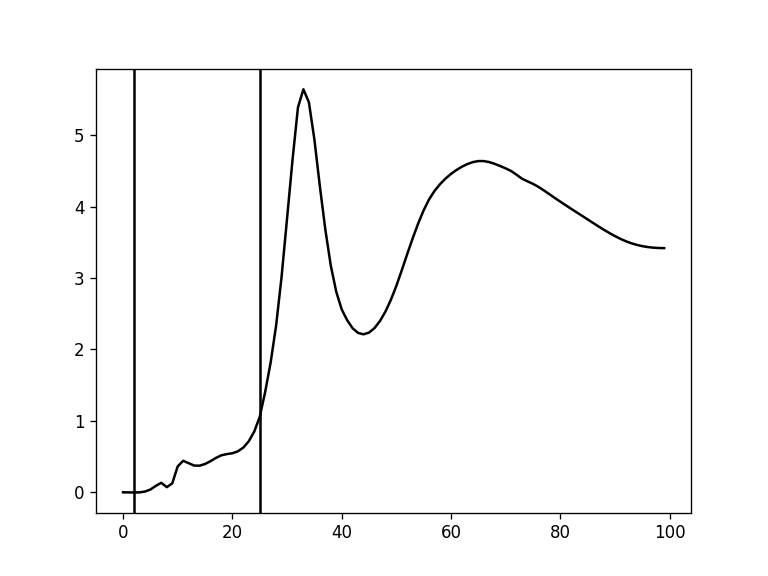

In [76]:
figure()
plot(3.8*ferro_spline(np.linspace(7.110, 7.170,100)),color='k')
axvline(2,color='k')
axvline(25,color='k')

<IPython.core.display.Javascript object>


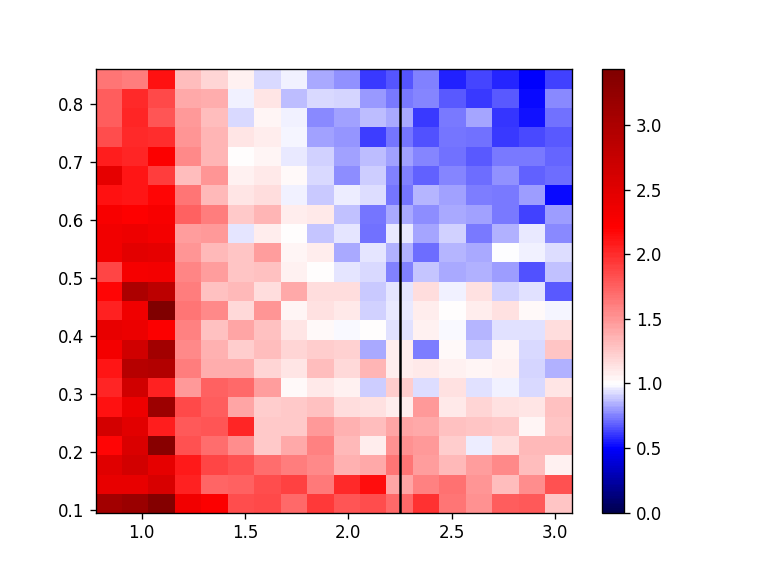

In [69]:
plot_phase_space('poisson gaussian', fnames, save=False, roi=slice(2,25), name_mod='pre_edge')

<IPython.core.display.Javascript object>


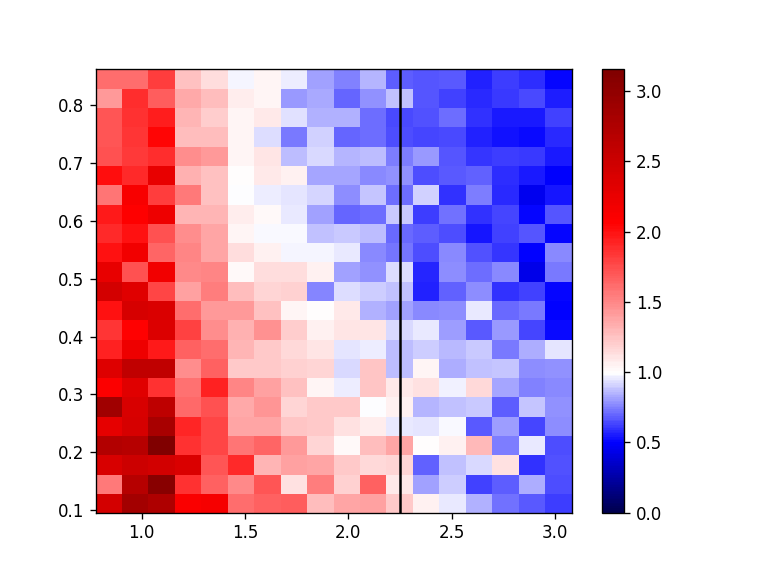

In [68]:
plot_phase_space('poisson', fnames, save=False, roi=slice(2,25), name_mod='pre_edge')